# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# maximum width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [18]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame, Window, functions as F
from pyspark.sql.types import IntegerType, FloatType, DecimalType, DoubleType
from typing import Dict, Any

from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [19]:
import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# create a Spark session
spark = SparkSession.builder.appName('Vikas_app').getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
# reading the mini_sparkify_event_data.json data into spark RDD
df = spark.read.json('mini_sparkify_event_data.json')

In [6]:
# sample records
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [6]:
#File schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [10]:
# customized descibe function to explain the data
def describe(df:DataFrame):
    """
    A function to run a descriptive analysis
    """
    
    check_flag=1    
    
    for feat in df.columns:
        
        feat = (
            df.select(feat)
            .agg(
                F.count(F.col(feat).isNotNull()).alias("count_N"),
                F.sum(F.when((F.col(feat).isNull()) | (F.col(feat) == ''),F.lit(1)).otherwise(F.lit(0))).alias("count_Miss"),
                F.countDistinct(feat).alias("distinct_values"),
                F.sum(F.col(feat)).cast(DecimalType(21, 2)).alias("sum"),
                F.mean(F.col(feat)).alias("mean"),
                F.stddev(F.col(feat)).alias("stddev"),
                F.min(F.col(feat)).alias("min"),
                F.max(F.col(feat)).alias("max")
            )
            .withColumn("feature", F.lit(feat))
            .select(
                "feature",
                "count_N",
                "count_Miss",
                "distinct_values",
                "sum",
                "mean",
                "stddev",
                "min",
                "max",
            )
        )
        if check_flag == 1:
            final = feat
            check_flag = 0
        else:
            final = final.union(feat)
        
        df_final = final.withColumn(
            "P_Miss",
            F.coalesce(
                (F.col("count_Miss") / (F.col("count_Miss") + F.col("count_N"))) * 100,
                F.lit(0.0),
            ).cast(DecimalType(5, 2)),
        )
            

    
    return df_final


In [11]:
df_recon=describe(df)

In [12]:
# printing the metrics to understand the data
df_recon.select("feature","count_N","count_Miss","P_Miss","distinct_values","mean").show()

+-------------+-------+----------+------+---------------+--------------------+
|      feature|count_N|count_Miss|P_Miss|distinct_values|                mean|
+-------------+-------+----------+------+---------------+--------------------+
|       artist| 286500|     58392| 16.93|          17655|   551.0852017937219|
|         auth| 286500|         0|  0.00|              4|                null|
|    firstName| 286500|      8346|  2.83|            189|                null|
|       gender| 286500|      8346|  2.83|              2|                null|
|itemInSession| 286500|         0|  0.00|           1322|  114.41421291448516|
|     lastName| 286500|      8346|  2.83|            173|                null|
|       length| 286500|     58392| 16.93|          14865|    249.117181977835|
|        level| 286500|         0|  0.00|              2|                null|
|     location| 286500|      8346|  2.83|            114|                null|
|       method| 286500|         0|  0.00|           

In [12]:
#Dropping the missing user ids
df_clean= df.filter(F.col("userId")!='')

In [12]:
df_clean.count()

278154

In [13]:
df.count()

286500

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [13]:
def explore_analysis(df, col):

    return df.groupBy(F.col(col)).count().orderBy(F.col('count').desc()).show(20)

def explore_user_analysis(df, col):

    return df.groupBy(F.col(col)).agg(F.countDistinct("userId").alias("distinct_users")).orderBy(F.col('distinct_users').desc()).show(20)

In [15]:
#type of authetication
explore_analysis(df_clean,'auth')

+---------+------+
|     auth| count|
+---------+------+
|Logged In|278102|
|Cancelled|    52|
+---------+------+



In [16]:
# distinct users against authetication
explore_user_analysis(df_clean,'auth')

+---------+--------------+
|     auth|distinct_users|
+---------+--------------+
|Logged In|           225|
|Cancelled|            52|
+---------+--------------+



In [17]:
explore_analysis(df_clean,'gender')

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
+------+------+



In [41]:
# users by gender
explore_user_analysis(df_clean,'gender')

+------+--------------+
|gender|distinct_users|
+------+--------------+
|     M|           121|
|     F|           104|
+------+--------------+



In [18]:
# pages visited by users
explore_user_analysis(df_clean,'page')

+--------------------+--------------+
|                page|distinct_users|
+--------------------+--------------+
|            NextSong|           225|
|                Home|           223|
|           Thumbs Up|           220|
|     Add to Playlist|           215|
|              Logout|           213|
|         Roll Advert|           207|
|          Add Friend|           206|
|         Thumbs Down|           203|
|            Settings|           195|
|                Help|           192|
|             Upgrade|           168|
|               About|           155|
|           Downgrade|           154|
|       Save Settings|           132|
|      Submit Upgrade|           131|
|               Error|           117|
|              Cancel|            52|
|Cancellation Conf...|            52|
|    Submit Downgrade|            49|
+--------------------+--------------+



In [85]:
# songs played by users
explore_user_analysis(df_clean,'song')

+--------------------+--------------+
|                song|distinct_users|
+--------------------+--------------+
|                null|           224|
|      You're The One|           190|
|             Revelry|           177|
|                Undo|           176|
|       Sehr kosmisch|           172|
|Horn Concerto No....|           164|
|Dog Days Are Over...|           162|
|        Use Somebody|           155|
|             Secrets|           144|
|SinceritÃÂ© Et J...|           140|
|              Canada|           140|
|    Ain't Misbehavin|           138|
|       ReprÃÂ©sente|           134|
|          Love Story|           133|
|           Fireflies|           133|
|Catch You Baby (S...|           132|
|    Hey_ Soul Sister|           132|
|            The Gift|           130|
|             Invalid|           130|
|              Yellow|           128|
+--------------------+--------------+
only showing top 20 rows



In [86]:
# different user agents 
explore_user_analysis(df_clean,'userAgent')

+--------------------+--------------+
|           userAgent|distinct_users|
+--------------------+--------------+
|"Mozilla/5.0 (Win...|            24|
|Mozilla/5.0 (Wind...|            18|
|"Mozilla/5.0 (Mac...|            16|
|"Mozilla/5.0 (Mac...|            12|
|"Mozilla/5.0 (Mac...|            12|
|"Mozilla/5.0 (Mac...|            10|
|"Mozilla/5.0 (Win...|            10|
|Mozilla/5.0 (Maci...|             9|
|"Mozilla/5.0 (iPh...|             8|
|"Mozilla/5.0 (Mac...|             7|
|"Mozilla/5.0 (Win...|             7|
|Mozilla/5.0 (Wind...|             7|
|"Mozilla/5.0 (Win...|             5|
|"Mozilla/5.0 (iPh...|             4|
|"Mozilla/5.0 (X11...|             4|
|Mozilla/5.0 (Wind...|             4|
|Mozilla/5.0 (X11;...|             4|
|"Mozilla/5.0 (Win...|             4|
|"Mozilla/5.0 (Win...|             4|
|"Mozilla/5.0 (Win...|             4|
+--------------------+--------------+
only showing top 20 rows



In [42]:
# different user level
explore_user_analysis(df_clean,'level')

+-----+--------------+
|level|distinct_users|
+-----+--------------+
| free|           195|
| paid|           165|
+-----+--------------+



In [29]:
# different type of status
explore_analysis(df_clean,'status')

+------+------+
|status| count|
+------+------+
|   200|254718|
|   307| 23184|
|   404|   252|
+------+------+



In [87]:
# Users from different locations
explore_user_analysis(df_clean,'location')

+--------------------+--------------+
|            location|distinct_users|
+--------------------+--------------+
|Los Angeles-Long ...|            16|
|New York-Newark-J...|            15|
|Dallas-Fort Worth...|             7|
|Phoenix-Mesa-Scot...|             7|
|    St. Louis, MO-IL|             6|
|Chicago-Napervill...|             6|
|Charlotte-Concord...|             6|
|Philadelphia-Camd...|             5|
|Miami-Fort Lauder...|             5|
|Boston-Cambridge-...|             5|
|Atlanta-Sandy Spr...|             4|
|Washington-Arling...|             4|
|Houston-The Woodl...|             4|
|San Diego-Carlsba...|             3|
|Las Vegas-Henders...|             3|
|New Haven-Milford...|             3|
|Providence-Warwic...|             2|
|San Antonio-New B...|             2|
|Indianapolis-Carm...|             2|
|         Jackson, MS|             2|
+--------------------+--------------+
only showing top 20 rows



In [14]:
# pages visits by distinct users
df_pages_pd=df_clean.groupBy(F.col('page')).agg(F.countDistinct("userId").alias("distinct_users")).orderBy(F.col('distinct_users').desc()).toPandas()

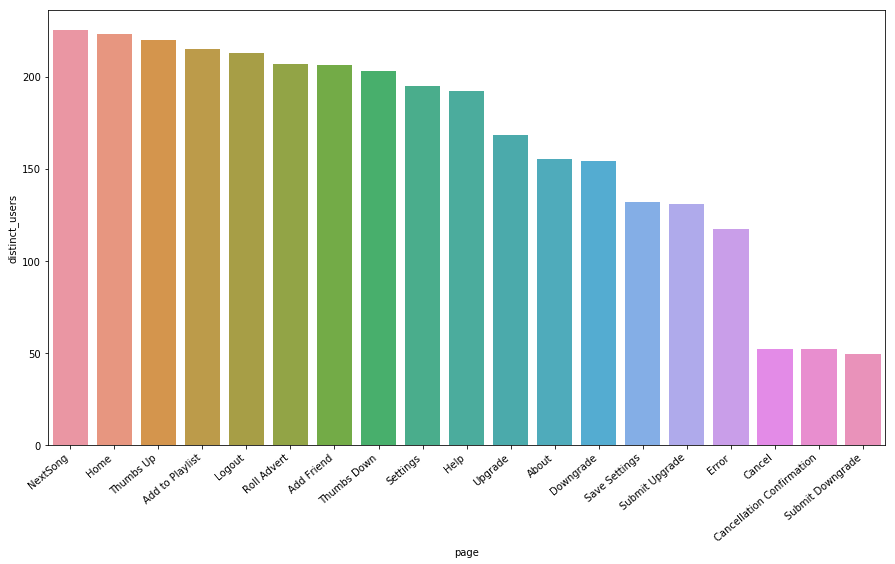

In [16]:
# plotting the charts
dims = (15, 8)
fig, ax = plt.subplots(figsize=dims)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
sns.barplot(ax=ax,x='page',y='distinct_users',data=df_pages_pd);

In [46]:
#users by location
df_loc_pd=df_clean.groupBy(F.col('location')).agg(F.countDistinct("userId").alias("distinct_users")).orderBy(F.col('distinct_users').desc()).toPandas()

In [50]:
df_loc_pd.head()

,location,distinct_users
0,"Los Angeles-Long Beach-Anaheim, CA",16
1,"New York-Newark-Jersey City, NY-NJ-PA",15
2,"Phoenix-Mesa-Scottsdale, AZ",7
3,"Dallas-Fort Worth-Arlington, TX",7
4,"St. Louis, MO-IL",6


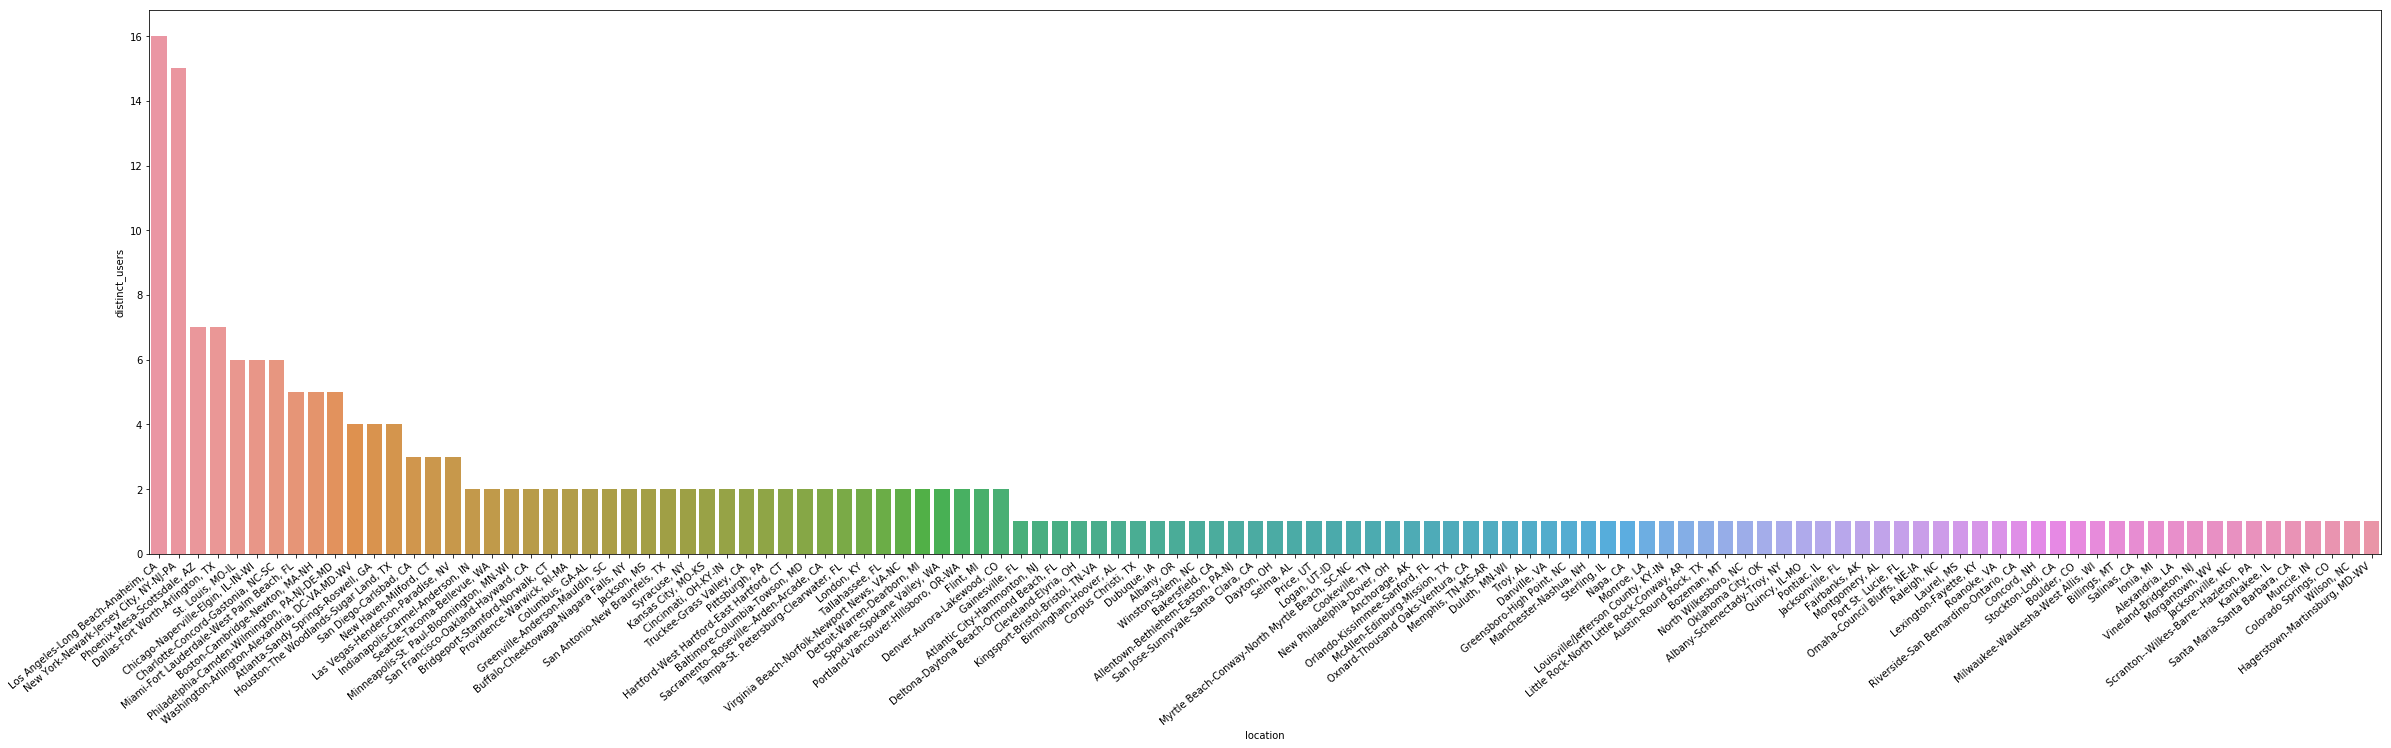

In [61]:
# plotting users chart by location
dims = (40, 10)
fig, ax = plt.subplots(figsize=dims)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
sns.barplot(ax=ax,x='location',y='distinct_users',data=df_loc_pd);

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [18]:
#define the flag event to transform event to 0 or 1 - This will be use for churn flag
event = F.udf(lambda x : 1 if x=='Cancellation Confirmation' else 0, IntegerType())

In [19]:
#define the current churn flag
df_clean_churn = df_clean.withColumn('Churn',event('page'))

In [20]:
# churn users
explore_user_analysis(df_clean_churn,'Churn')

+-----+--------------+
|Churn|distinct_users|
+-----+--------------+
|    0|           225|
|    1|            52|
+-----+--------------+



In [21]:
df_clean_churn_user=df_clean_churn.groupBy(F.col("userId")).agg(F.max("Churn").alias("Churn"))

In [24]:
df_clean_churn_user.show(5)

+------+-----+
|userId|Churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|    51|    1|
|   124|    0|
+------+-----+
only showing top 5 rows



In [22]:
df_churn=df_clean.join(df_clean_churn_user, ["userId"], "inner")

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [23]:
# creating a customized function to summarize churn against attributes in data
def eda_churn(df, col):

    return df.groupBy(F.col("Churn"),F.col(col)).agg(F.countDistinct("userId").alias("distinct_users")).orderBy(F.col('distinct_users').desc())

In [24]:
#churn against authentication
eda_churn(df_churn,'auth').show()

+-----+---------+--------------+
|Churn|     auth|distinct_users|
+-----+---------+--------------+
|    0|Logged In|           173|
|    1|Cancelled|            52|
|    1|Logged In|            52|
+-----+---------+--------------+



In [189]:
# validating churn flag
eda_churn(df_clean_churn,'page').show()

+-----+--------------------+--------------+
|Churn|                page|distinct_users|
+-----+--------------------+--------------+
|    0|            NextSong|           225|
|    0|                Home|           223|
|    0|           Thumbs Up|           220|
|    0|     Add to Playlist|           215|
|    0|              Logout|           213|
|    0|         Roll Advert|           207|
|    0|          Add Friend|           206|
|    0|         Thumbs Down|           203|
|    0|            Settings|           195|
|    0|                Help|           192|
|    0|             Upgrade|           168|
|    0|               About|           155|
|    0|           Downgrade|           154|
|    0|       Save Settings|           132|
|    0|      Submit Upgrade|           131|
|    0|               Error|           117|
|    1|Cancellation Conf...|            52|
|    0|              Cancel|            52|
|    0|    Submit Downgrade|            49|
+-----+--------------------+----

In [195]:
# Churn users against page visits
eda_churn(df_churn,'page').filter(F.col('churn')==1).show(20)

+-----+--------------------+--------------+
|Churn|                page|distinct_users|
+-----+--------------------+--------------+
|    1|Cancellation Conf...|            52|
|    1|              Cancel|            52|
|    1|            NextSong|            52|
|    1|                Home|            51|
|    1|         Roll Advert|            50|
|    1|     Add to Playlist|            50|
|    1|           Thumbs Up|            50|
|    1|         Thumbs Down|            48|
|    1|              Logout|            46|
|    1|          Add Friend|            44|
|    1|                Help|            43|
|    1|            Settings|            43|
|    1|             Upgrade|            37|
|    1|           Downgrade|            35|
|    1|               About|            31|
|    1|       Save Settings|            30|
|    1|      Submit Upgrade|            29|
|    1|               Error|            22|
|    1|    Submit Downgrade|             9|
+-----+--------------------+----

In [29]:
# gender against churn
eda_churn(df_churn,'gender').show()

+-----+------+--------------+
|Churn|gender|distinct_users|
+-----+------+--------------+
|    0|     M|            89|
|    0|     F|            84|
|    1|     M|            32|
|    1|     F|            20|
+-----+------+--------------+



In [30]:
# churn by level of subscription
eda_churn(df_churn,'level').show()

+-----+-----+--------------+
|Churn|level|distinct_users|
+-----+-----+--------------+
|    0| free|           149|
|    0| paid|           129|
|    1| free|            46|
|    1| paid|            36|
+-----+-----+--------------+



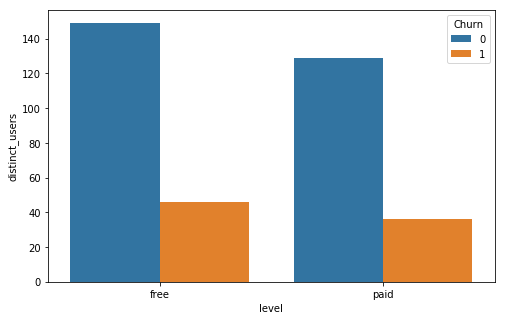

In [25]:
dims = (8, 5)
fig, ax = plt.subplots(figsize=dims)
sns.barplot(ax=ax,x='level',y='distinct_users',hue="Churn",data=eda_churn(df_churn,'level').toPandas())

In [31]:
df_churn.groupBy(F.col("Churn")).agg(        
                F.sum(F.col('length')).cast(DecimalType(21, 2)).alias("sum"),
                F.mean(F.col('length')).alias("mean"),
                F.stddev(F.col('length')).alias("stddev"),
                F.min(F.col('length')).alias("min"),
                F.max(F.col('length')).alias("max")
            ).show()

+-----+-----------+------------------+------------------+-------+----------+
|Churn|        sum|              mean|            stddev|    min|       max|
+-----+-----------+------------------+------------------+-------+----------+
|    1| 9048741.96|248.63279564406218|102.38497717575477|4.04853|3024.66567|
|    0|47776880.18|249.20913538880816|  98.6258830014688|0.78322|3024.66567|
+-----+-----------+------------------+------------------+-------+----------+



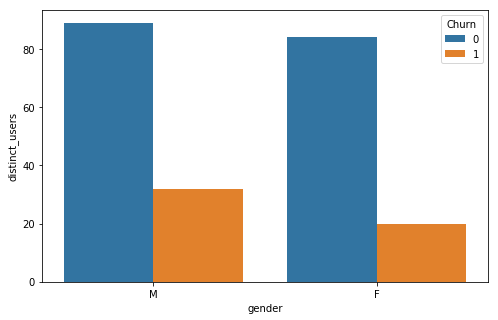

In [32]:
dims = (8, 5)
fig, ax = plt.subplots(figsize=dims)
sns.barplot(ax=ax,x='gender',y='distinct_users',hue="Churn",data=eda_churn(df_churn,'gender').toPandas())

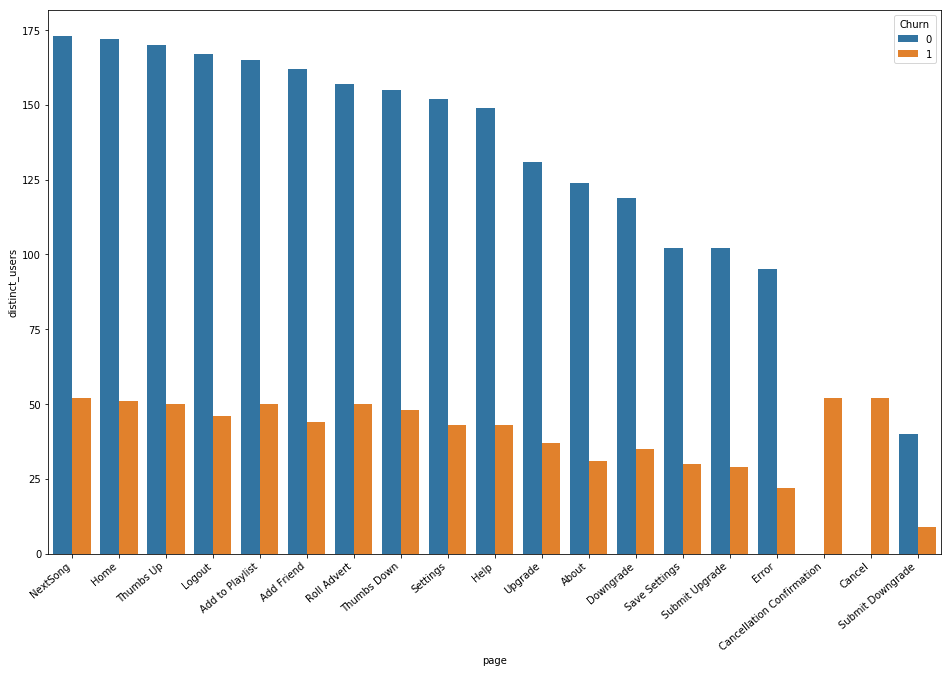

In [35]:
# Churn users against each page
dims = (16, 10)
fig, ax = plt.subplots(figsize=dims)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
sns.barplot(ax=ax,x='page',y='distinct_users',hue="Churn",data=eda_churn(df_churn,'page').toPandas())

In [40]:
# getting city and state from location column
city_state_split = F.split(df_churn['location'], ',')
df_churn_loc = (df_churn
            .withColumn('city',city_state_split.getItem(0))
            .withColumn('state',city_state_split.getItem(1))
           )


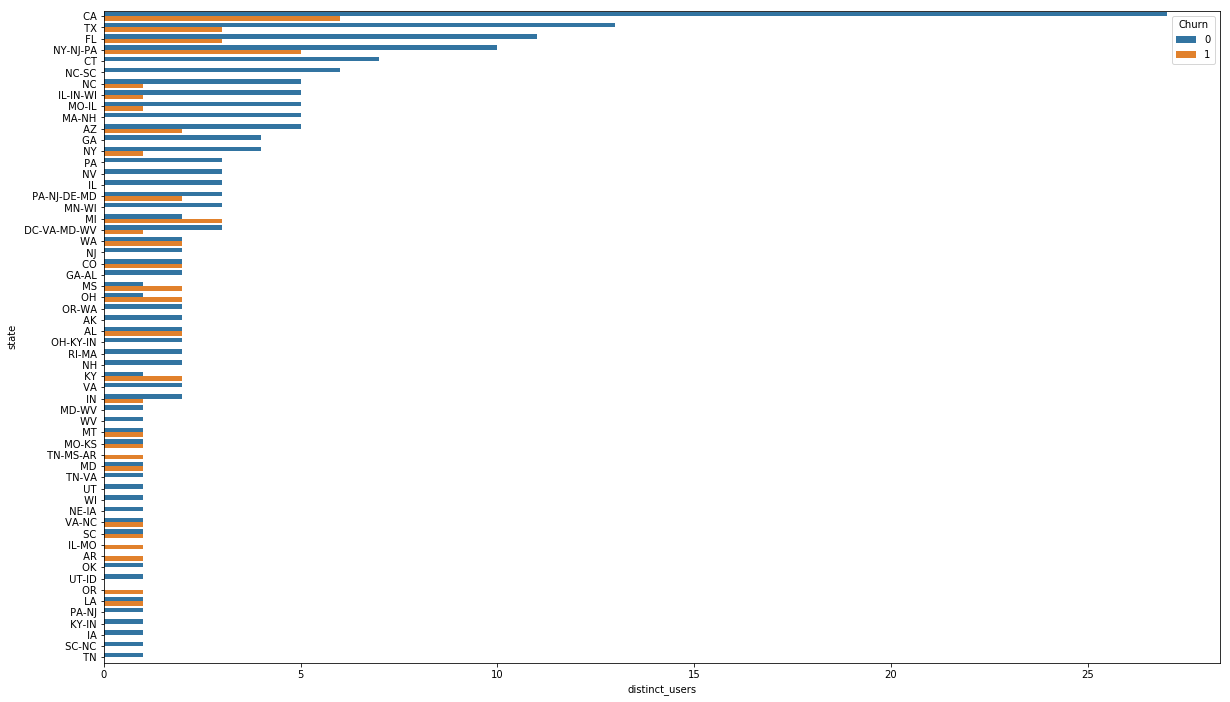

In [41]:
# users analysis by state
dims = (20, 12)
fig, ax = plt.subplots(figsize=dims)
sns.barplot(ax=ax,x='distinct_users',y='state',hue="Churn",data=eda_churn(df_churn_loc,'state').toPandas())

There is more users from CA state using sparkify services

In [42]:
# lets get the browser and operating system details from userAgent column
df_churn_loc.select("userAgent").distinct().show(20, False)

+-------------------------------------------------------------------------------------------------------------------------------------------+
|userAgent                                                                                                                                  |
+-------------------------------------------------------------------------------------------------------------------------------------------+
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                 |
|"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                                   |
|Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0                                                                 |
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"                 |
|"Mozi

In [65]:
# formatting date time column
get_date_time = F.udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

In [70]:
# getting the users browser details and applying get_date_time
df_churn_platform = (df_churn_loc
                     .withColumn('browser',F.when(F.locate('Firefox',F.col('userAgent')) > 0,'Firefox')
                                 .when(F.locate('Chrome',F.col('userAgent')) > 0,'Chrome')
                                 .when(F.locate('Safari',F.col('userAgent')) > 0,'Safari')
                                 .when(F.locate('Trident',F.col('userAgent')) > 0,'IE')
                                 .otherwise('Unknown'))
                     .withColumn("ts_date_time", get_date_time(F.col('ts')))
                     
                    )

In [82]:
# creatingm days of week, day of month, month and hours variable from time stamp
df_churn_final=(df_churn_platform
                .withColumn("ts_dayofweek", F.dayofweek(F.col('ts_date_time'))) 
                .withColumn("ts_dayofmonth", F.dayofmonth(F.col('ts_date_time')))
                .withColumn("ts_weekofyear", F.weekofyear(F.col('ts_date_time')))
                .withColumn("ts_month", F.month(F.col('ts_date_time')))
                .withColumn("ts_hour", F.hour(F.col('ts_date_time')))
               )

In [76]:
df_churn_final.select('ts_hour').distinct().show()

+-------+
|ts_hour|
+-------+
|     12|
|     22|
|      1|
|     13|
|     16|
|      6|
|      3|
|     20|
|      5|
|     19|
|     15|
|     17|
|      9|
|      4|
|      8|
|     23|
|      7|
|     10|
|     21|
|     11|
+-------+
only showing top 20 rows



In [49]:
# Churn users by browser
eda_churn(df_churn_platform,'browser').show()

+-----+-------+--------------+
|Churn|browser|distinct_users|
+-----+-------+--------------+
|    0| Chrome|            92|
|    0| Safari|            36|
|    0|Firefox|            34|
|    1| Chrome|            25|
|    1|Firefox|            16|
|    0|     IE|            11|
|    1| Safari|            10|
|    1|     IE|             1|
+-----+-------+--------------+



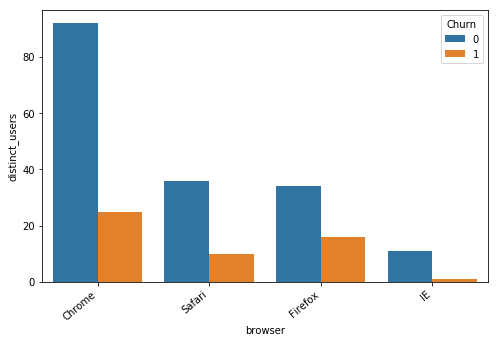

In [52]:
# bar chart for churn users by browser
dims = (8, 5)
fig, ax = plt.subplots(figsize=dims)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
sns.barplot(ax=ax,x='browser',y='distinct_users',hue="Churn",data=eda_churn(df_churn_platform,'browser').toPandas())

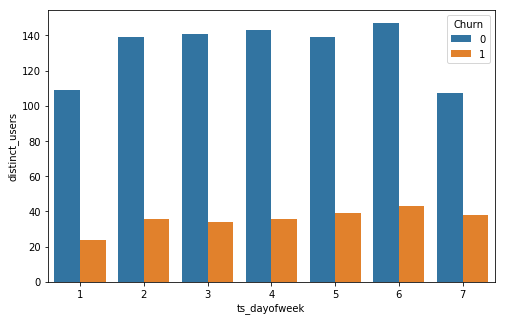

In [77]:
#churn users by day of week
dims = (8, 5)
fig, ax = plt.subplots(figsize=dims)
sns.barplot(ax=ax,x='ts_dayofweek',y='distinct_users',hue="Churn",data=eda_churn(df_churn_final,'ts_dayofweek').toPandas())

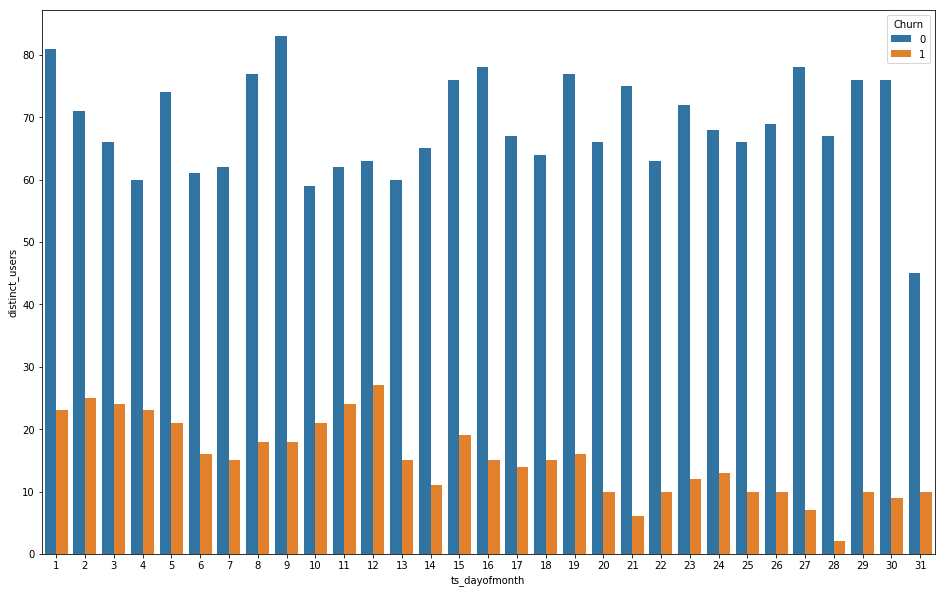

In [81]:
# churn and active users by day of month
dims = (16, 10)
fig, ax = plt.subplots(figsize=dims)
sns.barplot(ax=ax,x='ts_dayofmonth',y='distinct_users',hue="Churn",data=eda_churn(df_churn_final,'ts_dayofmonth').toPandas())

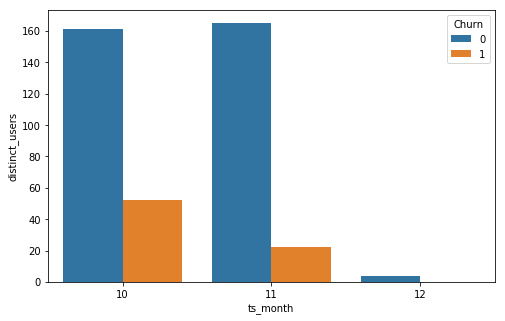

In [83]:
# Churn and active user by month
dims = (8, 5)
fig, ax = plt.subplots(figsize=dims)
sns.barplot(ax=ax,x='ts_month',y='distinct_users',hue="Churn",data=eda_churn(df_churn_final,'ts_month').toPandas())

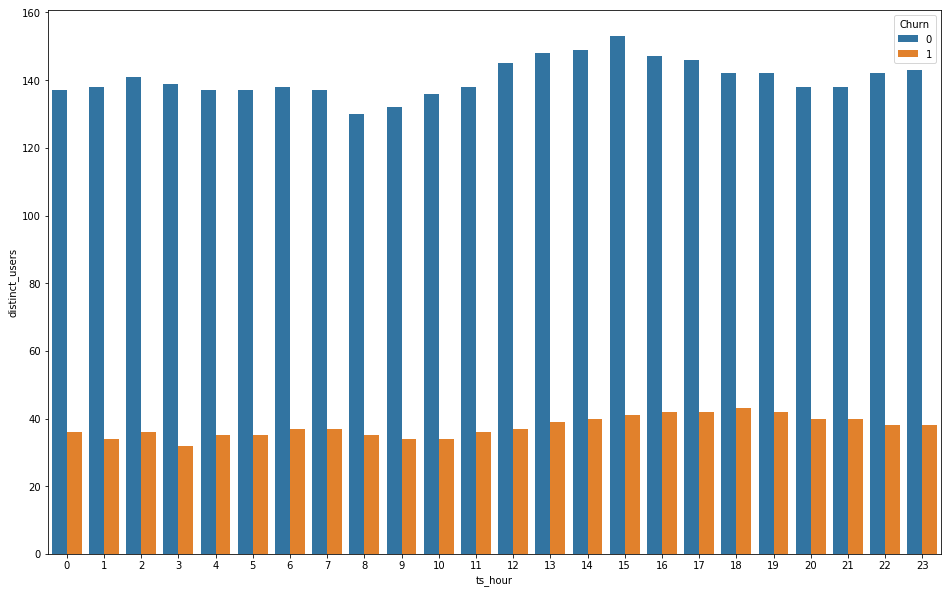

In [80]:
# churn and active users by hours
dims = (16, 10)
fig, ax = plt.subplots(figsize=dims)
sns.barplot(ax=ax,x='ts_hour',y='distinct_users',hue="Churn",data=eda_churn(df_churn_final,'ts_hour').toPandas())

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [88]:
df_churn_final.printSchema()

root
 |-- userId: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- browser: string (nullable = false)
 |-- ts_date_time: string (nullable = true)
 |-- ts_dayofweek: integer (nullable = true)
 |-- ts_dayofmonth: integer (nullable = true)
 |-- ts_weekofyear: 

In [167]:
def initial_load(file):
    """
    read the input json file
    
    output: spark RDD
    """
    df=spark.read.json(file)
    
    return df

def clean_data(df):
    """
    input RDD 
    
    perform following task:
    removing the rows with missing user id
    format the timstamp column
    create date and week variable
    
    returns clean dataframe
    """
    
    # dropping missing user ids
    df_clean= df.filter(F.col("userId")!='')
    
    # formatting date time variable
    get_date_time = F.udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
    
    # create browser used and timestamp variable
    df_dttime = (df_clean
                     .withColumn('browser',F.when(F.locate('Firefox',F.col('userAgent')) > 0,'Firefox')
                                 .when(F.locate('Chrome',F.col('userAgent')) > 0,'Chrome')
                                 .when(F.locate('Safari',F.col('userAgent')) > 0,'Safari')
                                 .when(F.locate('Trident',F.col('userAgent')) > 0,'IE')
                                 .otherwise('Unknown'))
                     .withColumn("ts_date_time", get_date_time(F.col('ts')))
                     
                    )
    
    # create month and hour variable  - we might use them later or not
    
    df_clean_final=(df_dttime
                .withColumn("ts_dayofweek", F.dayofweek(F.col('ts_date_time'))) 
                .withColumn("ts_dayofmonth", F.dayofmonth(F.col('ts_date_time')))
                .withColumn("ts_weekofyear", F.weekofyear(F.col('ts_date_time')))
                .withColumn("ts_month", F.month(F.col('ts_date_time')))
                .withColumn("ts_hour", F.hour(F.col('ts_date_time')))
               )
    return df_clean_final

    
def target_churn(df):
    """
    define target variable churn
    
    returns :
    df_churn - a dataframe with all the rows where churn flag is applied
    df_churn_by_user - Binary churn flag - unique row by user
    
    
    """
    
    #define the flag event to transform event to 0 or 1 - This will be use for churn flag
    event = F.udf(lambda x : 1 if x=='Cancellation Confirmation' else 0, IntegerType())
    
    #define the current churn flag
    df_event = df.withColumn('Churn',event('page'))

    df_churn_by_user=df_event.groupBy(F.col("userId")).agg(F.max("Churn").alias("Churn"))
    df_churn=df.join(df_churn_by_user, ["userId"], "inner")
    
    return df_churn, df_churn_by_user
    

def clean_column_name(column_name: str) -> str:
    """
    Refactor pandas column names including lower casing,
    and replacement of non-alpha characters with underscores or words.
    Args:
        column_name(str): a 'dirty' column name
    Returns:
        column_name(str): a 'clean' column name
   """
    column_new = column_name.lower()
    column_new = re.sub(r"[ :_\-]+", "_", column_new)
    column_new = re.sub("#", "number", column_new)
    column_new = re.sub("%", "percent", column_new)
    column_new = re.sub("[&+]+", "and", column_new)
    column_new = re.sub("[|,/;]+", "or", column_new)
    column_new = column_new.replace("?", "")
    column_new = column_new.replace("(", "")
    column_new = column_new.replace(")", "")
    column_new = column_new.replace("\r", "")
    column_new = re.sub(">=", "greater_than_or_equal_to_", column_new)
    column_new = re.sub("<=", "less_than_or_equal_to_", column_new)

    return column_new

def clean_spark_column_names(
    spark_df: DataFrame, prefix: str = "", suffix: str = "", spine=[]
) -> DataFrame:
    """
    Refactor spark column names including lower casing,
    and replacement of non-alpha characters with underscores or words.
    Args:
        spark_df(pyspark.sql.dataframe.DataFrame): a dataframe
        prefix: string to be prepended to cleaned column names, except for spine columns
        suffix: string to be appended to cleaned column names, except from spine columns
    Returns:
        spark_df(pyspark.sql.dataframe.DataFrame): dataframe with column names in lowercase and non-alpha characters
        substituted
    """

    if prefix:
        prefix = f"{prefix}_"

    if suffix:
        suffix = f"_{suffix}"

    cleaned = [clean_column_name(column) for column in spark_df.columns]
    renamed = [f"{prefix}{col}{suffix}" for col in cleaned if col not in spine]
    columns = spine + renamed
    return spark_df.toDF(*columns)

def label_encoding(df, col):
    '''
    creating dummy variables
    '''
    df_cat_list = df.select(F.col(col)).dropDuplicates().toPandas()

    label_dict = {val:str(idx) for idx,val in enumerate(df_cat_list[col].tolist())}
    df_cat = df.dropDuplicates(['userId']).select(['userId',col]).replace(label_dict,subset=col)
    
    df_cat = df_cat.withColumn(col,F.col(col).cast(IntegerType()))
    
    return df_cat

def get_avg_visit_per_page(df):
    
    """
    This function would be used to count total visits per page by each users. 
    
    input - spark data frame 
    output - transposed outout with number of visits to each page
    """
    
    # count number of visit per page
    df_page = (df_churn.groupBy(F.col("userId"),F.col("page")).agg(
        F.count(F.col('page')).alias("user_visit")            
    )
    )
    
    # transpose the data
        
    df_pivot=df_page.groupBy(["userId"]).pivot("page").agg(F.first('user_visit')).fillna(0)
    
    return df_pivot


def feature_engineering(df):
    """
    build features for modelling
    """
    
    # number of songs, artist, avg length , # of pages
    
    # total duration length spent by users
    df_song_duration= (df.groupBy(F.col("userId")).agg(        
                F.sum(F.col('length')).cast(DecimalType(21, 2)).alias("user_length_sum"),
                F.mean(F.col('length')).alias("user_length_avg"),
                F.stddev(F.col('length')).alias("user_length_stddev"),
                F.min(F.col('length')).alias("user_length_min"),
                F.max(F.col('length')).alias("user_length_max")
            ))
    
    # pages visit by users - dropiing the Cancellation Confirmation page as it is used to define target variable
    df_page_visit = get_avg_visit_per_page(df).drop("Cancellation Confirmation","cancel")
    
    # total # of page visits by users
    df_total_visit = df_page_visit.withColumn('total_page_visit', sum([F.col(col) for col in df_page_visit.columns if col not in['userId']]))
    
    # total number of songs, unique songs player by users
    
    df_songs_player = (df.filter(F.col('page')=='NextSong').groupBy(F.col('userId'))
                       .agg(F.countDistinct("song").alias("unique_songs"),
                            F.count("song").alias("total_songs"),
                            F.countDistinct("artist").alias("unique_artist")) 
                      )
    
    # total monthly, weekly and daily visits by users
    window = Window.partitionBy(['userId','sessionId']).orderBy(F.col("ts").desc())
    df_session=(df.select('userId','sessionId','ts','ts_date_time','ts_month','ts_weekofyear',F.row_number().over(window).alias("cnt"))
           .filter(F.col("cnt")==1)
           .drop("cnt")
          )
    
    # avg visit by month - we have considered them unique by login session
    df_visits_month=(df_session.groupBy(F.col("userId"), F.col("ts_month")).agg(F.count(F.col('sessionId')).alias('monthly_visit'))
                 .groupBy(F.col("userId")).agg(F.mean(F.col('monthly_visit')).alias('avg_monthly_visit')))
    
    # avg visit by week - we have considered them unique by login session
    df_visits_week=(df_session.groupBy(F.col("userId"), F.col("ts_weekofyear")).agg(F.count(F.col('sessionId')).alias('weekly_visit'))
                 .groupBy(F.col("userId")).agg(F.mean(F.col('weekly_visit')).alias('avg_weekly_visit')))
    
    
    # label encoding on categorical variable
    df_gender = label_encoding(df,'gender')    
    df_level = label_encoding(df,'level')
    df_browser = label_encoding(df,'browser')
    
    #merging all the data to create a final RDD
    
    df_result= (df_song_duration
                .join(df_total_visit,["userId"], "left")
                .join(df_songs_player,["userId"], "left")
                .join(df_visits_month,["userId"], "left")
                .join(df_visits_week,["userId"], "left")
                .join(df_gender,["userId"], "left")
                .join(df_level,["userId"], "left")
                .join(df_browser,["userId"], "left")
               )
    
    
    
    return df_result


In [168]:
def main():
    
    """
    Main function to perform data load and feature engineering tasks
    1) it will will load the data from spark jason file
    2) data cleaning 
    3) creating features
    
    this function will not return anyrhing
    
    """
    
    # load the data 
    df=initial_load('mini_sparkify_event_data.json')
    
    # clean the data 
    
    df_clean=clean_data(df)
    
    # create target vraibles - churn flag
    
    df_churn, df_churn_by_user=target_churn(df_clean)
    
    # build features 
    
    df_features=feature_engineering(df_churn)
    
    # append target variable 
    
    df_features_with_target = df_features.join(df_churn_by_user,['userId'],'left')
    
    # clean spark columnnames 
    
    df_final=clean_spark_column_names(df_features_with_target)
    
    #fill NaN
    df_final = df_final.na.fill(0)
    
    # save the final file 
    
    df_final.write.save('final_fea_event_data.json',format='json',header=True,mode="overwrite")
    
    df_final.printSchema()
    
    
    
if __name__ == '__main__':
    main()

root
 |-- userid: string (nullable = true)
 |-- user_length_sum: decimal(21,2) (nullable = true)
 |-- user_length_avg: double (nullable = false)
 |-- user_length_stddev: double (nullable = false)
 |-- user_length_min: double (nullable = false)
 |-- user_length_max: double (nullable = false)
 |-- about: long (nullable = true)
 |-- add_friend: long (nullable = true)
 |-- add_to_playlist: long (nullable = true)
 |-- downgrade: long (nullable = true)
 |-- error: long (nullable = true)
 |-- help: long (nullable = true)
 |-- home: long (nullable = true)
 |-- logout: long (nullable = true)
 |-- nextsong: long (nullable = true)
 |-- roll_advert: long (nullable = true)
 |-- save_settings: long (nullable = true)
 |-- settings: long (nullable = true)
 |-- submit_downgrade: long (nullable = true)
 |-- submit_upgrade: long (nullable = true)
 |-- thumbs_down: long (nullable = true)
 |-- thumbs_up: long (nullable = true)
 |-- upgrade: long (nullable = true)
 |-- total_page_visit: long (nullable = tru

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [15]:
#feature Scaling 

def feature_scaling(df):
    # I have been dropping the browser column it's not having a postive impact on the model
    feature_cols = df.drop('userid', 'churn','browser').columns
    assembler = VectorAssembler(inputCols=feature_cols,\
                                outputCol='feature_vec')
    
    #pyspark.ml expects target column to be names: 'labelCol', w/ type: Double
    df = df.withColumn("label", df["churn"].cast(DoubleType())).drop("churn")
    
    #pyspark default name for features vector column: 'featuresCol'
    minmaxscaler = MinMaxScaler(inputCol="feature_vec", outputCol="features")
    
    df = assembler.transform(df)
    minmaxscaler_model = minmaxscaler.fit(df)
    scaled_df = minmaxscaler_model.transform(df)
    return scaled_df

In [169]:
feature_cols = df_features.drop('userid', 'churn').columns

In [170]:
feature_cols

['about',
 'add_friend',
 'add_to_playlist',
 'avg_monthly_visit',
 'avg_weekly_visit',
 'browser',
 'cancel',
 'downgrade',
 'error',
 'gender',
 'help',
 'home',
 'level',
 'logout',
 'nextsong',
 'roll_advert',
 'save_settings',
 'settings',
 'submit_downgrade',
 'submit_upgrade',
 'thumbs_down',
 'thumbs_up',
 'total_page_visit',
 'total_songs',
 'unique_artist',
 'unique_songs',
 'upgrade',
 'user_length_avg',
 'user_length_max',
 'user_length_min',
 'user_length_stddev',
 'user_length_sum']

In [16]:
df_features=spark.read.json('final_fea_event_data.json')

In [20]:
df_scaling=feature_scaling(df_features)

In [117]:
df_scaling.take(1)

[Row(about=0, add_friend=19, add_to_playlist=23, avg_monthly_visit=10.5, avg_weekly_visit=2.3333333333333335, browser=2, cancel=0, churn=0, downgrade=10, error=2, gender=0, help=6, home=66, level=0, logout=19, nextsong=942, roll_advert=86, save_settings=2, settings=11, submit_downgrade=2, submit_upgrade=3, thumbs_down=11, thumbs_up=35, total_page_visit=1245, total_songs=942, unique_artist=733, unique_songs=881, upgrade=8, user_length_avg=245.73289733545636, user_length_max=1485.97506, user_length_min=34.32444, user_length_stddev=93.07552168990236, user_length_sum=231480.39, userid='100004', label=0.0, feature_vec=DenseVector([0.0, 19.0, 23.0, 10.5, 2.3333, 0.0, 10.0, 2.0, 6.0, 66.0, 19.0, 942.0, 86.0, 2.0, 11.0, 2.0, 3.0, 11.0, 35.0, 1245.0, 942.0, 733.0, 881.0, 8.0, 245.7329, 1485.9751, 34.3244, 93.0755, 231480.39]), features=DenseVector([0.0, 0.1329, 0.0958, 0.181, 0.1224, 0.0, 0.137, 0.2857, 0.1304, 0.1859, 0.1532, 0.1174, 0.6719, 0.2, 0.2115, 0.6667, 0.75, 0.1467, 0.0801, 0.1287, 0

In [21]:
#Creating test, train and validation dataset
train, test_validation_sample = df_scaling.randomSplit([0.80, 0.20], seed=123)

In [22]:
#Creating test, train and validation dataset
validation, test = test_validation_sample.randomSplit([0.5,0.5], seed=123)

In [201]:
train.printSchema()

root
 |-- about: long (nullable = true)
 |-- add_friend: long (nullable = true)
 |-- add_to_playlist: long (nullable = true)
 |-- avg_monthly_visit: double (nullable = true)
 |-- avg_weekly_visit: double (nullable = true)
 |-- browser: long (nullable = true)
 |-- downgrade: long (nullable = true)
 |-- error: long (nullable = true)
 |-- gender: long (nullable = true)
 |-- help: long (nullable = true)
 |-- home: long (nullable = true)
 |-- level: long (nullable = true)
 |-- logout: long (nullable = true)
 |-- nextsong: long (nullable = true)
 |-- roll_advert: long (nullable = true)
 |-- save_settings: long (nullable = true)
 |-- settings: long (nullable = true)
 |-- submit_downgrade: long (nullable = true)
 |-- submit_upgrade: long (nullable = true)
 |-- thumbs_down: long (nullable = true)
 |-- thumbs_up: long (nullable = true)
 |-- total_page_visit: long (nullable = true)
 |-- total_songs: long (nullable = true)
 |-- unique_artist: long (nullable = true)
 |-- unique_songs: long (nullabl

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

def model_custom_evaluation(data, model):
    '''
    Evaluation of model prediction
    
    1. Using PySpark.ML evaluator 
    2. use RDD-API; PySpark.MLLib to get metrics based on predictions 
    3. display confusion matrix
    
    Inputs
        preds(PySpark.ml.DataFrame) - predictions from model
    '''
    
    auprc = BinaryClassificationEvaluator(metricName='areaUnderPR')
    
    auc_pr=auprc.evaluate(data)
    
    print(f"{model} -> PR AUC: {auc_pr}")
    
    predRDD = data.select(['label', 'prediction']).rdd\
                        .map(lambda line: (line[1], line[0]))
    metrics = MulticlassMetrics(predRDD)

    print(f"{model}\n | precision = {metrics.precision()}")
    print(f" | recall = {metrics.recall()}\n | F1-Score = {metrics.fMeasure()}")
    
    conf_matrix = metrics.confusionMatrix().toArray()
    sns.set(font_scale=1.4)
    ax = sns.heatmap(conf_matrix, annot=True,annot_kws={"size": 16})
    ax.set(xlabel='Prediction', ylabel='True', title='Confusion Matrix -'f"{model}")
    plt.show()

Random Forest -> PR AUC: 0.3293795093795094
Random Forest
 | precision = 0.782608695652174
 | recall = 0.782608695652174
 | F1-Score = 0.782608695652174


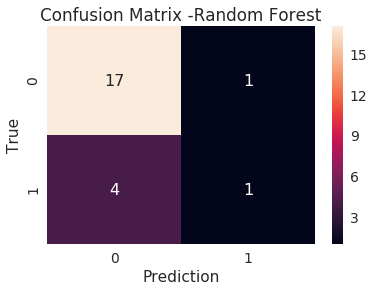

In [25]:
# applying random forest model 
random_forest = RandomForestClassifier(numTrees=10)
random_forest_model = random_forest.fit(train)
random_forest_pred = random_forest_model.transform(validation)
model_custom_evaluation(random_forest_pred, 'Random Forest')

Gradient Boosted Trees -> PR AUC: 0.5944155844155844
Gradient Boosted Trees
 | precision = 0.6521739130434783
 | recall = 0.6521739130434783
 | F1-Score = 0.6521739130434783


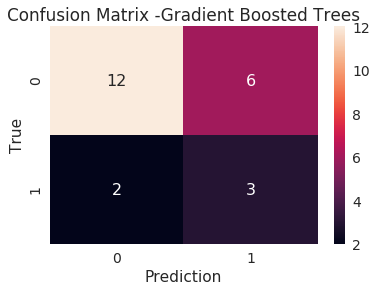

In [26]:
#gradient boosted trees (ie ada boost)
gbtrees = GBTClassifier(maxIter=10)
gbtree_model = gbtrees.fit(train)
gbtree_preds = gbtree_model.transform(validation)
model_custom_evaluation(gbtree_preds, 'Gradient Boosted Trees')

Support Vector Machine -> PR AUC: 0.43934267486899065
Support Vector Machine
 | precision = 0.782608695652174
 | recall = 0.782608695652174
 | F1-Score = 0.782608695652174


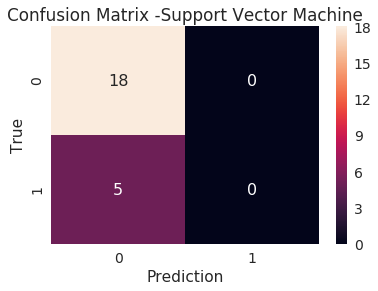

In [30]:
svm = LinearSVC(maxIter=5, regParam=0.1)
svm_model=svm.fit(train)
svm_preds=svm_model.transform(validation)
model_custom_evaluation(svm_preds, 'Support Vector Machine')

Logistic Regression -> PR AUC: 0.21739130434782608
Logistic Regression
 | precision = 0.782608695652174
 | recall = 0.782608695652174
 | F1-Score = 0.782608695652174


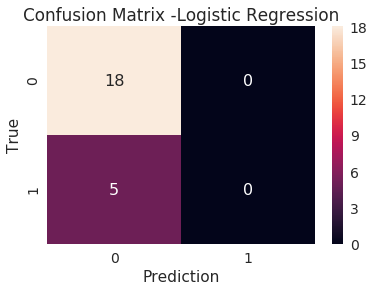

In [28]:
#logistic regression model
logReg = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
lrModel = logReg.fit(train)
lr_preds = lrModel.transform(validation)
model_custom_evaluation(lr_preds, 'Logistic Regression')

In [29]:
#visual check for predictions
for x in [svm_preds, lr_preds, gbtree_preds, random_forest_pred]:
    x.select('features', 'rawPrediction', 'prediction', 'label').show(5)

+--------------------+--------------------+----------+-----+
|            features|       rawPrediction|prediction|label|
+--------------------+--------------------+----------+-----+
|[0.0,0.0069930069...|[1.23546510013656...|       0.0|  0.0|
|[0.0,0.0419580419...|[1.69301728688853...|       0.0|  1.0|
|[0.04,0.013986013...|[0.83413060010804...|       0.0|  1.0|
|[0.04,0.104895104...|[1.10677118638982...|       0.0|  0.0|
|[0.08,0.160839160...|[0.65645274979582...|       0.0|  0.0|
+--------------------+--------------------+----------+-----+
only showing top 5 rows

+--------------------+--------------------+----------+-----+
|            features|       rawPrediction|prediction|label|
+--------------------+--------------------+----------+-----+
|[0.0,0.0069930069...|[1.15267950993838...|       0.0|  0.0|
|[0.0,0.0419580419...|[1.15267950993838...|       0.0|  1.0|
|[0.04,0.013986013...|[1.15267950993838...|       0.0|  1.0|
|[0.04,0.104895104...|[1.15267950993838...|       0.0|  0.0|

In [132]:
# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", metricName = 'areaUnderPR')
for x in [svm_preds, lr_preds, gbtree_preds, rf_preds]:
    print(x,evaluator.evaluate(x))

DataFrame[about: bigint, add_friend: bigint, add_to_playlist: bigint, avg_monthly_visit: double, avg_weekly_visit: double, browser: bigint, cancel: bigint, churn: bigint, downgrade: bigint, error: bigint, gender: bigint, help: bigint, home: bigint, level: bigint, logout: bigint, nextsong: bigint, roll_advert: bigint, save_settings: bigint, settings: bigint, submit_downgrade: bigint, submit_upgrade: bigint, thumbs_down: bigint, thumbs_up: bigint, total_page_visit: bigint, total_songs: bigint, unique_artist: bigint, unique_songs: bigint, upgrade: bigint, user_length_avg: double, user_length_max: double, user_length_min: double, user_length_stddev: double, user_length_sum: double, userid: string, label: double, feature_vec: vector, features: vector, rawPrediction: vector, prediction: double] 1.0
DataFrame[about: bigint, add_friend: bigint, add_to_playlist: bigint, avg_monthly_visit: double, avg_weekly_visit: double, browser: bigint, cancel: bigint, churn: bigint, downgrade: bigint, error:

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.